# 뉴스 크롤링

In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
from tqdm import tqdm
import sys
import re
import pandas as pd

In [2]:
search = "킥보드 주차"

url_list = []

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

for page in tqdm(range(1, 2000, 10)):
    url = f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query={search}&start={page}&nso=so:r,p:1y"
    
    raw_html = requests.get(url, headers=headers)
    html = BeautifulSoup(raw_html.text, "html.parser")
    
    for item in html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info"):
        if "news.naver.com" in item["href"]:
            url_list.append(item["href"])

            
len(url_list)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.83it/s]


683

In [3]:
news_titles = []
news_contents = []
news_dates = []
news_urls = []

pattern1 = "<[^>]*>"
pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""


for url in tqdm(url_list):
    raw_html = requests.get(url, headers=headers)
    html = BeautifulSoup(raw_html.text, "html.parser")
    
    title = html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
    if title == None:
        title = html.select_one("#content > div.end_ct > div > h2")
    title = re.sub(pattern=pattern1, repl="", string=str(title))
    
    content = html.select("div#dic_area")
    if content == []:
        content = html.select("#articeBody")
    content = "".join(str(content))
    content = re.sub(pattern=pattern1, repl="", string=content)
    content = content.replace(pattern2, "")
    
    if ("주차" not in title) and ("주차" not in content):
        continue
    
    try:
        html_date = html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
        news_date = html_date.attrs["data-date-time"]
    except AttributeError:
        news_date = html.select_one("#content > div.end_ct > div > div.article_info > span > em")
        news_date = re.sub(pattern=pattern1, repl="", string=str(news_date))
    
    news_titles.append(title)
    news_contents.append(content)
    news_dates.append(news_date)
    news_urls.append(url)

    
print("news_title: ", len(news_titles))
print("news_url: ", len(news_urls))
print("news_contents: ", len(news_contents))
print("news_dates: ", len(news_dates))

df = pd.DataFrame({"date": news_dates, "title": news_titles, "link": news_urls, "content": news_contents})
df = df.drop_duplicates(keep="first", ignore_index=True)
print("중복 제거 후 행 개수: ", len(df))

now = datetime.datetime.now() 
df.to_csv("./data/news_{}_{}.csv".format(search, now.strftime("%Y%m%d_%H시%M분%S초")), encoding="utf-8-sig", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 683/683 [02:31<00:00,  4.50it/s]

news_title:  681
news_url:  681
news_contents:  681
news_dates:  681
중복 제거 후 행 개수:  573


In [4]:
df.head()

,date,title,link,content
0,2023-01-18 12:12:08,"佛 파리, 공유 킥보드 몸살에 4월 2일 찬반투표",https://n.news.naver.com/mnews/article/421/000...,"[\n파리시장 '금지가 해결책', 교통장관 '금지가 능사는 아니야... 해결책 마련..."
1,2023-01-16 10:25:01,전동 킥보드 전용 주차구역 설치.. 이용 제한 구역도 지정,https://n.news.naver.com/mnews/article/661/000...,[\n\n\n\n\n전동 킥보드를 포함한 개인형 이동장치 전용 주차구역이 설치됩니다...
2,2023-01-16 20:49:03,전동 킥보드에 몸살 앓는 파리...대여 금지 주민 찬반 투표,https://n.news.naver.com/mnews/article/021/000...,[\n\n\n\n\n대여 전동 킥보드를 이용하는 파리 시민. AP 뉴시스 안전·주...
3,2023-01-16 11:02:01,공유 킥보드도 메타버스에 등장,https://n.news.naver.com/mnews/article/469/000...,[\n\t\t\t공유 킥보드가 인터넷 가상공간인 메타버스에 등장한다.공유 킥보드 서...
4,2023-01-17 03:06:25,"골칫덩이 킥보드, 파리선 투표로 존폐 결정",https://n.news.naver.com/mnews/article/023/000...,"[\n[정철환의 유로 포커스]사고 빈발, 널브러져 보기 싫다\n\n\n\n파리 시내..."


# 뉴스 기사 분석

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

from konlpy.tag import Okt, Komoran
import nltk
from collections import Counter

from wordcloud import WordCloud
from PIL import Image
from gensim.models import word2vec

In [6]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [7]:
okt = Okt()
komoran = Komoran()

In [8]:
def stopword(stop_list):
    stopwords = []
    
    stopword_file = open("./data/stopwords-ko.txt", "r", encoding="utf8")
    # https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a#file-stopwords-ko-txt
    for line in stopword_file.readlines():
        stopwords.append(re.sub("\n", "", line))
    stopword_file.close()
    
    stopwords.extend(["통해", "위해", "인해"])
    stopwords.extend(stop_list)
    
    return stopwords


def clean_text(text):
    text = re.sub("[?.…,;:|\)*~`’!^\-_+<>@\#$%&-=#}]", " ", text)
    text = re.sub("[\n\t]", " ", text)
    text = re.sub("[^ ㄱ-ㅣ가-힣]+", "", text)
    
    return text


def tokenize(text):
    nouns = komoran.nouns(clean_text(text))
    return [n for n in nouns if (len(n) > 1) & (n not in stopwords)]

In [9]:
news_path = "./data/news_킥보드 주차_20230127_14시16분27초.csv"

## Word Cloud

In [10]:
stop_list = ["보드", "전동", "공유", "이동", "모빌리티", # 개인형 이동장치 명칭 관련 단어
             "티맵", "카카오", "라임", # 공유형 이동장치 운영 회사
             "서비스", "업체", "사업", "운영", "기업", "제공", # 공유형 이동장치 운영 관련 일반적인 단어
             "이용", "이용자", "사용",
             "기자", "관련", "지난해", "경우", "대부분"
             "때문", "보니", "모습", "대수", "개수", "건수", "개월", "대부분", "이후"]

In [11]:
news_data = pd.read_csv(news_path)

words_list = []
stopwords = stopword(stop_list)

for text in tqdm(news_data["content"]):
    words_list.extend(tokenize(text))

c = Counter(words_list)

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:33<00:00, 17.02it/s]


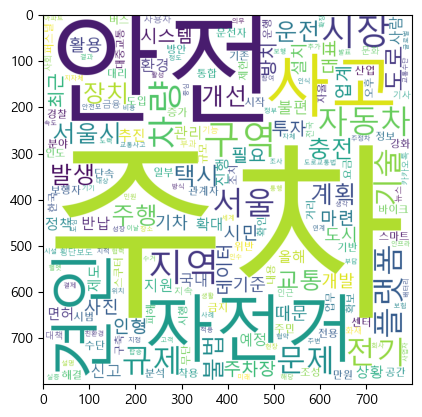

In [12]:
wc = WordCloud(font_path="malgun", width=400, height=400, scale=2.0, max_font_size=250, background_color="white")
gen = wc.generate_from_frequencies(c)
plt.figure()
plt.imshow(gen)

In [13]:
len(c.keys())

8879

## 빈도 그래프

In [14]:
news_data = pd.read_csv(news_path)

words_list = []
stopwords = stopword(stop_list)

for text in tqdm(news_data["content"]):
    words_list.extend(tokenize(text))
    
count = nltk.Text(words_list)

100%|████████████████████████████████████████████████████████████████████████████████| 573/573 [00:29<00:00, 19.36it/s]


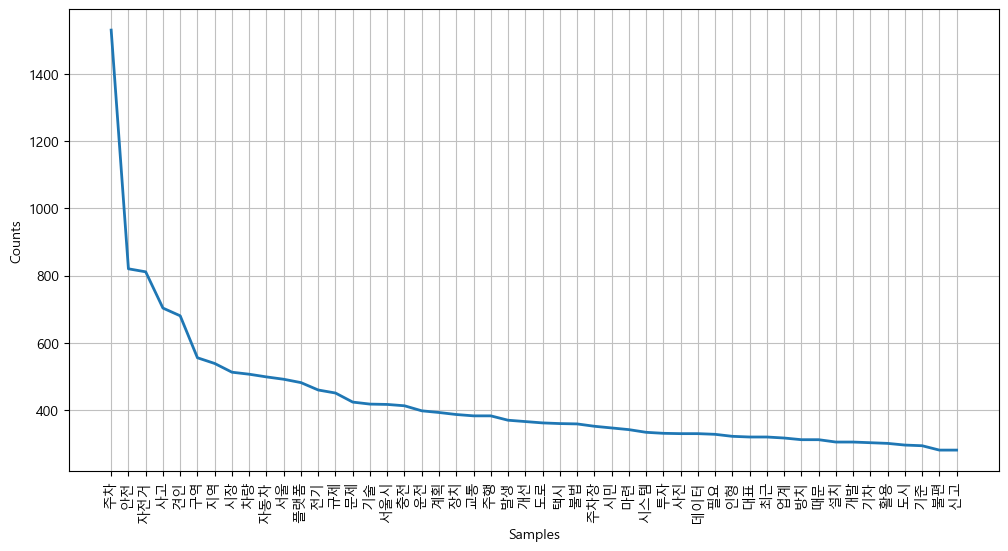

In [15]:
plt.figure(figsize=(12,6))
count.plot(50)
plt.show()

## 단어 유사도

In [16]:
stop_list = ["지난해", "전체", "때문", "개월", "보니", "모습", "대수", "경우", "대부분", "이후"]

In [17]:
news_data = pd.read_csv(news_path)

stopwords = stopword(stop_list)

tokens = news_data["content"].apply(tokenize)

In [18]:
model = word2vec.Word2Vec(tokens, min_count=1)
model

In [19]:
vocab = model.wv.key_to_index

print(len(vocab))
print(sorted(vocab, key=vocab.get, reverse=False)[:10])

8898
['보드', '전동', '모빌리티', '서비스', '주차', '공유', '이용', '사업', '업체', '이동']


In [20]:
model.wv.most_similar("불편", topn=30)

[('정차', 0.986244797706604),
 ('보행', 0.9860210418701172),
 ('한가운데', 0.9840940237045288),
 ('보도', 0.9830536842346191),
 ('곳곳', 0.9828959107398987),
 ('장소', 0.982133150100708),
 ('유발', 0.9818985462188721),
 ('안전사고', 0.9816595315933228),
 ('횡단', 0.9811931252479553),
 ('위험', 0.9796670079231262),
 ('속출', 0.9796303510665894),
 ('갓길', 0.9794846177101135),
 ('과속', 0.9792211055755615),
 ('운행', 0.9789493680000305),
 ('행위', 0.978803277015686),
 ('위협', 0.9787158370018005),
 ('도내', 0.9787006378173828),
 ('우회전', 0.9785239696502686),
 ('시민', 0.9784289598464966),
 ('원주', 0.9784137606620789),
 ('방지', 0.9776546359062195),
 ('점령', 0.9776121973991394),
 ('주의', 0.9771429300308228),
 ('건수', 0.9765666723251343),
 ('저해', 0.9764423966407776),
 ('출입구', 0.9761244654655457),
 ('차도', 0.9759331345558167),
 ('유턴', 0.9751718044281006),
 ('다발', 0.9749525189399719),
 ('진출입', 0.974598228931427)]

In [21]:
model.wv.most_similar("골칫거리", topn=30)

[('시내', 0.9941312670707703),
 ('원주', 0.9923226237297058),
 ('투표', 0.9898319840431213),
 ('한가운데', 0.9896469116210938),
 ('도나', 0.9885173439979553),
 ('점령', 0.9883046746253967),
 ('처리', 0.9882380366325378),
 ('춘천시', 0.9879204630851746),
 ('해당', 0.9877020120620728),
 ('분이', 0.987470269203186),
 ('과태료', 0.9872630834579468),
 ('벌금', 0.9868342280387878),
 ('징수', 0.9867462515830994),
 ('접수', 0.9863064289093018),
 ('진출입', 0.9861136078834534),
 ('파리', 0.9860072731971741),
 ('비용', 0.9856324195861816),
 ('광주시', 0.9853203892707825),
 ('도내', 0.9852021932601929),
 ('만원', 0.9847860336303711),
 ('시가', 0.9845923185348511),
 ('강제', 0.9844184517860413),
 ('제기', 0.9843589663505554),
 ('근거', 0.9843182563781738),
 ('불법행위', 0.9835208654403687),
 ('정차', 0.9834159016609192),
 ('지자체', 0.983318030834198),
 ('전주시', 0.9829815626144409),
 ('내야', 0.9828600287437439),
 ('패널', 0.9827275276184082)]

In [22]:
model.wv.most_similar("방해", topn=30)

[('통행', 0.9927248358726501),
 ('횡단보도', 0.9863017797470093),
 ('장소', 0.9815486073493958),
 ('지하철역', 0.9811564683914185),
 ('시민', 0.9785491824150085),
 ('전용', 0.9773924946784973),
 ('홍대입구역', 0.9767468571662903),
 ('안전사고', 0.9766241908073425),
 ('위반', 0.9763106107711792),
 ('보행', 0.9755150675773621),
 ('위협', 0.97551429271698),
 ('분별', 0.9751390814781189),
 ('유발', 0.9731264114379883),
 ('주소', 0.972093403339386),
 ('조례', 0.9719591736793518),
 ('보행자', 0.9717170596122742),
 ('개정', 0.9706268906593323),
 ('인도', 0.9690815210342407),
 ('건수', 0.9686760902404785),
 ('규정', 0.9682585597038269),
 ('주차공간', 0.9678658843040466),
 ('곳곳', 0.9657383561134338),
 ('이용자', 0.9654566645622253),
 ('법규', 0.9648089408874512),
 ('주차', 0.9645466208457947),
 ('기기', 0.9643740653991699),
 ('설치', 0.963071882724762),
 ('폭증', 0.9627016186714172),
 ('입구', 0.9625759720802307),
 ('과속', 0.9624448418617249)]